In [2]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
import importlib
import galaxy

In [3]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

# global star formation rate

In [4]:
sfr = {}
sfr['iso'] = np.genfromtxt(basepath + 'runs/MW7iso/lvl5-Ngb64/output/sfr.txt')
sfr['merge'] = np.genfromtxt(basepath + 'runs/MW7_GSE4/lvl5-denscut/output/sfr.txt')
sfr['burst'] = np.genfromtxt(basepath + 'runs/MW7iso/lvl5-Ngb64-artburst/output/sfr.txt')
sfr['burst-windE2'] = np.genfromtxt(basepath + 'runs/MW7iso/lvl5-Ngb64-artburst-windE2/output/sfr.txt')
sfr['burst-rhoth'] = \
    np.genfromtxt(basepath + 'runs/MW7iso/lvl5-Ngb64-artburst-rhothresh/output/sfr.txt')
sfr['burst-minwv350'] = \
    np.genfromtxt(basepath + 'runs/MW7iso/lvl5-Ngb64-artburst-minwv350/output/sfr.txt')
sfr['burst-auriga'] = \
    np.genfromtxt(basepath + 'runs/MW7iso/lvl5-Ngb64-artburst-auriga-begin3/output/sfr.txt')

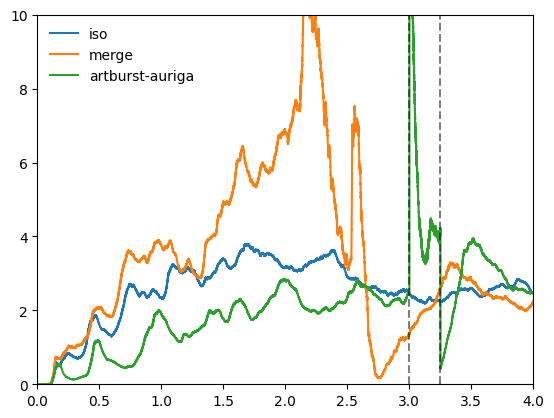

In [5]:
fig, ax = plt.subplots(1, 1)
ax.plot(sfr['iso'][:,0], sfr['iso'][:,2], label='iso')
ax.plot(sfr['merge'][:,0], sfr['merge'][:,2], label='merge')
# ax.plot(sfr['burst'][:,0], sfr['burst'][:,2], label='artburst')
# ax.plot(sfr['burst-windE2'][:,0], sfr['burst-windE2'][:,2])
# ax.plot(sfr['burst-rhoth'][:,0], sfr['burst-rhoth'][:,2])
# ax.plot(sfr['burst-minwv350'][:,0], sfr['burst-minwv350'][:,2], label='artburst-minwv350')
ax.plot(sfr['burst-auriga'][:,0], sfr['burst-auriga'][:,2], label='artburst-auriga')

ax.legend(frameon=False)
ax.set(xlim=(0, 4), ylim=(0, 10))
ax.axvline(3, c='k', ls='dashed', alpha=0.5)
ax.axvline(3.25, c='k', ls='dashed', alpha=0.5)

In [27]:
gals = {}
for snap in tqdm(np.arange(140+1)):
    try:
        gals[snap] = galaxy.Galaxy(basepath + 'runs/MW7_GSE4/lvl5-denscut/output', 
                                   snap, orient=True)
    except:        
        pass

100%|██████████| 141/141 [00:55<00:00,  2.53it/s]


In [5]:
gals = {}
for snap in tqdm(np.arange(400+1)):
    try:
        gals[snap] = galaxy.Galaxy(basepath + 'runs/MW7iso/lvl5-Ngb64/output', 
                                   snap, orient=True)
    except:        
        pass

100%|██████████| 401/401 [02:11<00:00,  3.04it/s]


In [46]:
gals_burst = {}
for snap in tqdm(np.arange(400+1)):
    try:
        gals_burst[snap] = galaxy.Galaxy(basepath + 'runs/MW7iso/lvl5-Ngb64-artburst-auriga-begin3/output', 
                                         snap, orient=True)
    except:
        pass

100%|██████████| 401/401 [00:52<00:00,  7.65it/s] 


In [47]:
def gas_mass_enc(gal, rcut=10):
    r = np.linalg.norm(gal.sn.part0.rotpos, axis=1)
    Menc = np.sum(gal.sn.part0.mass.value[r < rcut])
    if gal.sn.NumPart_Total[4] > 0:
        is_wind = gal.sn.part4.GFM_StellarFormationTime <= 0
        r = np.linalg.norm(gal.sn.part4.rotpos, axis=1)
        Menc += np.sum(gal.sn.part4.mass.value[r < rcut])
        Mwind = np.sum(gal.sn.part4.mass.value[is_wind])
    else:
        Mwind = 0
    
    return gal.sn.Time.value, Menc, Mwind

Time, Menc, Mwind = [], [], []
for snap in gals.keys():
    t, m, mw = gas_mass_enc(gals[snap])
    Time.append(t)
    Menc.append(m)
    Mwind.append(mw)
Time, Menc, Mwind = np.array(Time), np.array(Menc), np.array(Mwind)

Time_burst, Menc_burst, Mwind_burst = [], [], []
for snap in gals_burst.keys():
    t, m, mw = gas_mass_enc(gals_burst[snap])
    Time_burst.append(t)
    Menc_burst.append(m)
    Mwind_burst.append(mw)
Time_burst, Menc_burst, Mwind_burst = np.array(Time_burst), np.array(Menc_burst), np.array(Mwind_burst)

# Time_burst_wE2, Menc_burst_wE2 = [], []
# for snap in gals_burst_wE2.keys():
#     t, m = gas_mass_enc(gals_burst_wE2[snap])
#     Time_burst_wE2.append(t)
#     Menc_burst_wE2.append(m)
# Time_burst_wE2, Menc_burst_wE2 = np.array(Time_burst_wE2), np.array(Menc_burst_wE2)

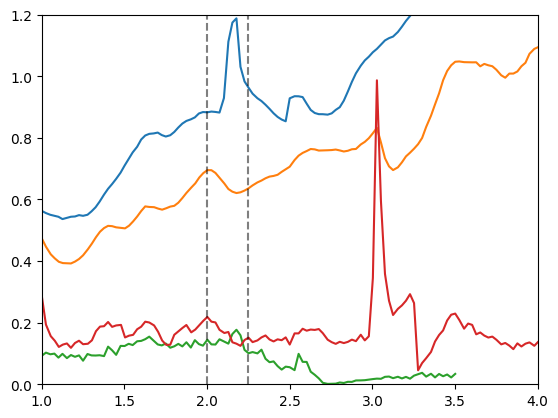

In [48]:
fig, ax = plt.subplots(1,1)
ax.plot(Time, Menc)
ax.plot(Time_burst, Menc_burst)
ax.plot(Time, 10*Mwind)
ax.plot(Time_burst, 10*Mwind_burst)
# ax.plot(Time_burst_wE2, Menc_burst_wE2)
ax.set_xlim(1, 4)
ax.set_ylim(0, 1.2)
ax.axvline(2, c='k', ls='dashed', alpha=0.5)
ax.axvline(2.25, c='k', ls='dashed', alpha=0.5)

In [ ]:
def get_inflow_outflow(gal, r0=12, dr=2, Rmax=12, zmax=3, subshell=False, print_shell=False):
    r = np.linalg.norm(gal.sn.part0.rotpos, axis=1)
    R = np.linalg.norm(gal.sn.part0.rotpos[:,:2], axis=1)
    z = gal.sn.part0.rotpos[:,2]
    in_shell = np.logical_and(r > r0-dr/2., r < r0 + dr/2.)
    # in_shell = np.logical_and(R < Rmax, np.abs(z) < zmax)
    
    rhat = gal.sn.part0.rotpos / r[:,np.newaxis]
    vel_r = np.sum((gal.sn.part0.rotvel) * rhat, axis=1)

    is_inflow = vel_r < 0
    inflow = np.sum(vel_r[is_inflow] * gal.sn.part0.mass.value[is_inflow])
        
    is_outflow = vel_r > 0
    outflow = np.sum(vel_r[is_outflow] * gal.sn.part0.mass.value[is_outflow])
    
    if gal.sn.NumPart_Total[4] > 0:
        is_wind = gal.sn.part4.GFM_StellarFormationTime <= 0
        r = np.linalg.norm(gal.sn.part4.rotpos, axis=1)
        R = np.linalg.norm(gal.sn.part4.rotpos[:,:2], axis=1)
        z = gal.sn.part4.rotpos[:,2]
        in_shell = np.logical_and(r > r0-dr/2., r < r0 + dr/2.)
        # in_shell = np.logical_and(R < Rmax, np.abs(z) < zmax)
            
        rhat = gal.sn.part4.rotpos / r[:,np.newaxis]
        vel_r = np.sum(gal.sn.part4.rotvel * rhat, axis=1)

        is_inflow = np.logical_and(vel_r < 0, is_wind)
        inflow += np.sum(vel_r[is_inflow] * gal.sn.part4.mass.value[is_inflow])
        
        is_outflow = np.logical_and(vel_r > 0, is_wind)
        outflow += np.sum(vel_r[is_outflow] * gal.sn.part4.mass.value[is_outflow])
    
    inflow /= dr
    outflow /= dr
    
    return inflow, outflow

# abundance plane

In [9]:
def get_logFeH_logMgFe(gal):
    GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
    GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
    GFM_SOLAR_ABUNDANCE_IRON   =   0.0013
    
    FeH = gal.sn.part4.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    logFeH = np.log10(FeH)

    MgH = gal.sn.part4.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    MgFe = MgH/FeH
    logMgH = np.log10(MgH)
    logMgFe = np.log10(MgFe)
    
    return logFeH, logMgH, logMgFe

In [41]:
def in_SN(gal, ptype, Rmin=4, Rmax=16, zmax=3):
    part = getattr(gal.sn, 'part'+str(ptype))
    R = np.linalg.norm(part.rotpos[:,:2], axis=1)
    z = part.rotpos[:,2]
    key_R = np.logical_and(R < Rmax, R > Rmin)
    key = np.logical_and(key_R, np.abs(z) < zmax)
    
    return key
    
def plot_map(fig, ax, gal, subsamp=None, tform_min=0, tform_max=10,
             Rmin=4, Rmax=16, zmax=3, exclude=None):
    
    # vmin = None
    # vmax = 0.008
    # vmax = None
    
    logFeH, logMgH, logMgFe = get_logFeH_logMgFe(gal)
    
    key = in_SN(gal, 4, Rmin=Rmin, Rmax=Rmax, zmax=zmax)
    
    tform = gal.sn.part4.GFM_StellarFormationTime
    key = np.logical_and(key, tform > tform_min)
    key = np.logical_and(key, tform < tform_max)
    
    if exclude is not None:
        key_low = np.logical_and(key, tform < exclude[0])
        key_high = np.logical_and(key, tform > exclude[1])
        key = np.logical_or(key_low, key_high)
    
    mass = np.copy(gal.sn.part4.mass.value)
    
    print(np.sum(mass[key]))
    
    if subsamp is not None and np.sum(key) > subsamp:
        key_w = np.where(key)[0]
        key_w = np.random.choice(key_w, subsamp, replace=False)
        key = np.full(len(key), False)
        key[key_w] = True
        print('subsampled to:', np.sum(key))

    # logFeH_bins  = np.linspace(-1, 0.75, 75)
    # logMgFe_bins = np.linspace(0.15, 0.4, 75)
    
    logFeH_bins  = np.linspace(-0.9, 0.6, 50)
    logMgFe_bins = np.linspace(-0.05, 0.45, 50) + 0.2

    mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[key], logMgFe[key], mass[key], 
                                                     statistic='sum', bins=[logFeH_bins, logMgFe_bins])

    # downstairs = np.max(mbin, axis=1)
    # vmin = 0.01
    # vmax = 0.15
    
    downstairs = np.sum(mbin, axis=1)
    vmin = 0.0
    vmax = 0.1
    
    downstairs[downstairs == 0.0] = 1e-20
    mbin = (mbin.T / downstairs).T
    mbin[mbin < vmin] = vmin
    
    extent = [x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]]
    
    # norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    norm = mpl.colors.PowerNorm(gamma=0.3)
    im = ax.imshow(mbin.T, origin='lower',
               extent=extent,
               norm=norm)

    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_aspect('auto')
    
    return im

In [54]:
snap = 196
gal = galaxy.Galaxy(basepath + 'runs/MW7_GSE4/lvl5-denscut-Ngb64-steep1/output', snap, orient=True)
gal_burst = galaxy.Galaxy(basepath + 'runs/MW7iso/lvl5-Ngb64-artburst-auriga-begin3/output', 
                                         snap, orient=True)

0.14325467
(0.0, 0.003087879291342688)
0.2900109
(0.0, 0.003087879291342688)


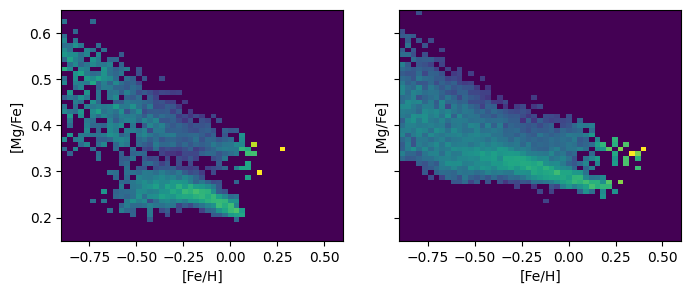

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)

# snap = 400

_ = plot_map(fig, axs[0], gal)
print(im.get_clim())
_ = plot_map(fig, axs[1], gal_burst)
print(im.get_clim())

axs[0].set_xlim(extent[0], extent[1])
axs[0].set_ylim(extent[2], extent[3])
axs[0].set_aspect('auto')
axs[1].set_aspect('auto')

axs[0].set(xlabel='[Fe/H]', ylabel='[Mg/Fe]');
axs[1].set(xlabel='[Fe/H]', ylabel='[Mg/Fe]');


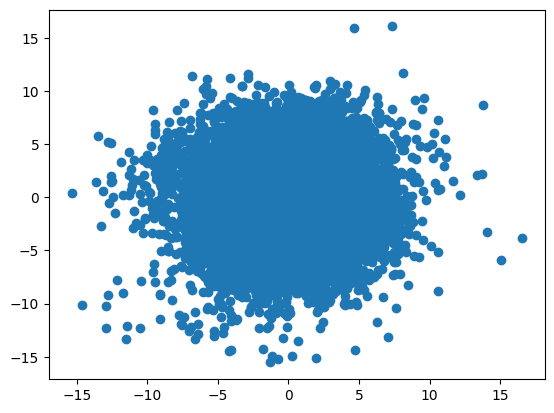

In [24]:
pos = gal_burst.sn.part4.pos.value - gal_burst.sub.SubhaloPos[0]
is_star = gal_burst.sn.part4.GFM_StellarFormationTime > 0
pos_star = pos[is_star]
plt.scatter(pos_star[:,0], pos_star[:,1])